## HDFS Storage prediction based on historical data
### Model: Linear Regression

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Import for date formatting
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

(2)a.First 5 rows of the dataset for sanity check:

         date  storage_gb
0  2024-05-01        3047
1  2024-05-02        3069
2  2024-05-03        3193
3  2024-05-04        3112
4  2024-05-05        2992


(2) b.Description and Shape of the dataset:

Description of the dataset:
        storage_gb
count   365.000000
mean   3548.980822
std     336.392035
min    2845.000000
25%    3264.000000
50%    3539.000000
75%    3822.000000
max    4286.000000


Shape of the dataset: (365, 2)


Training model...

Model Evaluation (on test data):
  Root Mean Squared Error (RMSE): 104.58 GB
  R-squared (R2): 0.92
  This R2 score means the model explains 92% of the variance.

Predicting storage for the next 120 days...

--- Future Predictions ---
        date  predicted_storage_gb
0 2025-05-01           4102.856465
1 2025-05-02           4105.883108
2 2025-05-03           4108.909751
3 2025-05-04           4111.936394
4 2025-05-05           4114.963037
...
Generating plot...

Plot saved to E:/0. MAC

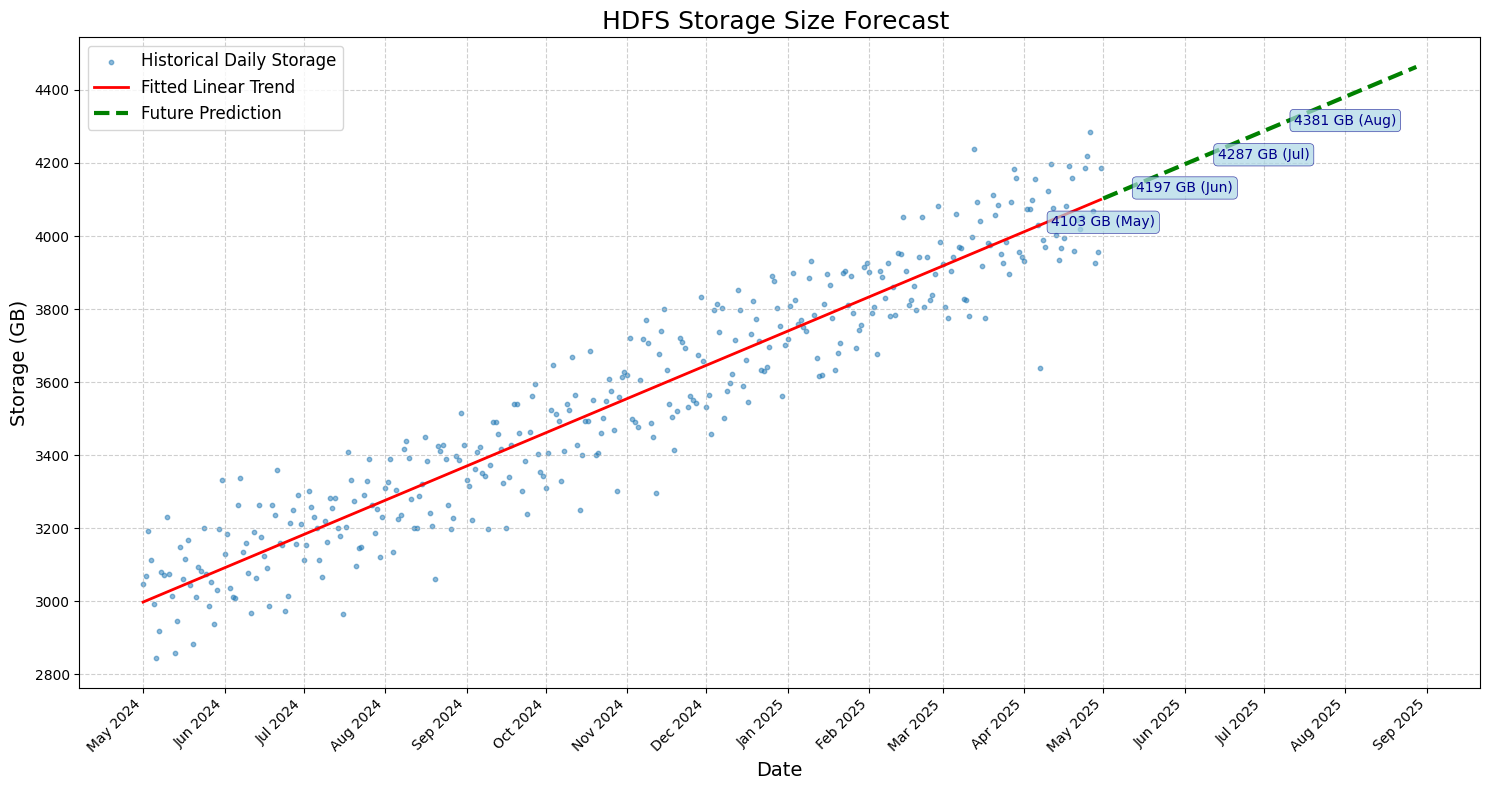

In [6]:
def load_data():
    file_path = "E:/0. MACHINE LEARNING/hdfs_storage_data.csv"

    # Read CSV File
    df = pd.read_csv(file_path)

    print("(2)a.First 5 rows of the dataset for sanity check:\n")
    print(df.head(5))
    print("\n" + "="*50 + "\n")

    print("(2) b.Description and Shape of the dataset:")

    # Print statistical description
    print("\nDescription of the dataset:")
    print(df.describe())
    print("\n" + "="*50 + "\n")

    # Print shape
    print(f"Shape of the dataset: {df.shape}")
    print("\n" + "="*50 + "\n")
    return df
    
def prepare_data(df):
    """
    Performs feature engineering to prepare data for the ML model.
    """
    # Ensure date column is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Create the primary feature: 'days_since_start'
    # This converts the date into a number the model can understand.
    df = df.sort_values(by='date').reset_index(drop=True)
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    
    return df

def train_model(df):
    """
    Trains a Linear Regression model on the historical data.
    """
    print("Training model...")
    # Define our feature (X) and target (y)
    # We use [[...]] to keep X as a 2D array (required by scikit-learn)
    X = df[['days_since_start']]
    y = df['storage_gb']
    
    # Split data for validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nModel Evaluation (on test data):")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f} GB")
    print(f"  R-squared (R2): {r2:.2f}")
    print(f"  This R2 score means the model explains {r2*100:.0f}% of the variance.")
    
    # For a final model to predict the future, we retrain on ALL data
    # to give it the most information.
    final_model = LinearRegression()
    final_model.fit(X, y)
    
    return final_model

def predict_future(model, historical_df, days_to_predict=30):
    """
    Predicts storage size for a number of days into the future.
    """
    print(f"\nPredicting storage for the next {days_to_predict} days...")
    
    # Find the last day number in our historical data
    last_date = historical_df['date'].max()
    last_day_number = historical_df['days_since_start'].max()
    
    # Create the 'days_since_start' values for the future
    # e.g., if last day was 364, this will be [365, 366, ..., 394]
    future_day_numbers = np.arange(last_day_number + 1, last_day_number + days_to_predict + 1)
    
    # Create a DataFrame for the future, just like the model was trained on
    future_X_df = pd.DataFrame(future_day_numbers, columns=['days_since_start'])
    
    # Generate future dates for the plot
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict, freq='D')
    
    # Make the predictions!
    future_storage_pred = model.predict(future_X_df) # Pass the DataFrame
    
    predictions_df = pd.DataFrame({
        'date': future_dates,
        'predicted_storage_gb': future_storage_pred
    })
    
    return predictions_df

def plot_results(historical_df, predictions_df, model):
    """
    Visualizes the historical data, the model's trend line, and future predictions.
    """
    print("Generating plot...")
    
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    
    # 1. Plot historical data
    plt.scatter(historical_df['date'], historical_df['storage_gb'], 
                label='Historical Daily Storage', alpha=0.5, s=10)
    
    # 2. Plot the model's fitted trend line over the historical data
    historical_X = historical_df[['days_since_start']]
    historical_trend = model.predict(historical_X)
    plt.plot(historical_df['date'], historical_trend, color='red', 
             linewidth=2, label='Fitted Linear Trend')
    
    # 3. Plot the future predictions and capture the line object for interactivity
    prediction_line, = plt.plot(predictions_df['date'], predictions_df['predicted_storage_gb'], 
             color='green', linestyle='--', linewidth=3, label='Future Prediction')
    
    # Define a consistent style for all static labels
    label_bbox_style = dict(boxstyle="round,pad=0.3", fc="lightblue", ec="darkblue", lw=0.5, alpha=0.7)
    
    # Only label the first day of every month in the forecast
    monthly_labels = predictions_df[predictions_df['date'].dt.day == 1]
    
    for _, row in monthly_labels.iterrows():
        label = f"{row['predicted_storage_gb']:.0f} GB ({row['date'].strftime('%b')})"
        plt.annotate(label, 
                     (row['date'], row['predicted_storage_gb']), 
                     textcoords="offset points", xytext=(0,-20), # Offset downward for clarity
                     ha='center', color='darkblue', fontsize=10, 
                     bbox=label_bbox_style)

    # Formatting
    plt.title('HDFS Storage Size Forecast ', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Storage (GB)', fontsize=14)
    plt.legend(fontsize=12)

    # Monthly Ticks and Formatting
    # Set the major ticks to appear every month
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    # Format the date labels to show abbreviated month and full year (e.g., Jan 2024)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    
    # Rotate date labels for better visibility
    plt.xticks(rotation=45, ha='right')
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
        
    # Save the plot (saves the static version)
    plot_filename = r'E:/0. MACHINE LEARNING/storage_forecast.png'
    plt.savefig(plot_filename)
    print(f"\nPlot saved to {plot_filename}")
    
    # Show the plot (This enables the interactive features if run locally)
    plt.show()

def main():
    # --- STEP 1: LOAD DATA ---

    df = load_data()
    
        
    # --- STEP 2: PREPARE DATA ---
    df_prepared = prepare_data(df)
    
    # --- STEP 3: TRAIN MODEL ---
    model = train_model(df_prepared)
    
    # --- STEP 4: PREDICT FUTURE ---
    predictions_df = predict_future(model, df_prepared, days_to_predict=120) # Predict 120 days out
    
    print("\n--- Future Predictions ---")
    print(predictions_df.head())
    print("...")
    
    # --- STEP 5: VISUALIZE ---
    plot_results(df_prepared, predictions_df, model)

if __name__ == "__main__":
    main()
